In [1]:
from __future__ import print_function

import os
import numpy as np
# import torch
# import pandas as pd
from io import StringIO
# from google.cloud import storage
import matplotlib.pyplot as plt#, mpld3
from sklearn import ensemble
from sklearn.preprocessing import MinMaxScaler
from scipy.misc import logsumexp
# Keras
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.metrics import binary_accuracy
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Input, Lambda, Wrapper, merge, concatenate
from keras.engine import InputSpec
from keras.layers.core import Dense, Dropout, Activation, Layer, Lambda, Flatten
from keras.regularizers import l2
from keras.optimizers import RMSprop, Adadelta, adam
from keras.layers.advanced_activations import LeakyReLU
from keras import initializers
import tensorflow as tf

import random
seed = 0 #0
np.random.seed(seed=seed)
random.seed(seed)

%matplotlib inline
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../ab2.json"

Using TensorFlow backend.


## Concrete Dropout layer
https://github.com/yaringal/ConcreteDropout/blob/master/concrete-dropout-keras.ipynb

In [2]:
class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input Dense layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers which have 2D
    kernels, not just `Dense`. However, Conv2D layers require different
    weighing of the regulariser (use SpatialConcreteDropout instead).
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        assert len(input_shape) == 2, 'this wrapper only supports Dense layers'
        input_dim = np.prod(input_shape[-1])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

# Load data from numpy arrays

In [3]:
def load_data_file(data_file, num_features):
    
    data = np.load(data_file)
    
    if data.ndim == 1:
        data = data[None, :]
    
    x = data[:, :num_features]
    y = data[:, num_features:]
    
    return x, y

In [4]:
num_features = 13
x_data, y_data = load_data_file(data_file='../../train/training_hela.npy', num_features=num_features)

In [5]:
Ntr = 70000
x_data_tr = x_data[:Ntr,:]
y_data_tr = y_data[:Ntr,:]
x_data_val = x_data[Ntr:,:]
y_data_val_un = y_data[Ntr:,:]

In [6]:
x_data.shape

(79999, 13)

# Training / Validation split

* Consider taking log 10 of data (Being careful not to take the log of the temperature features if they are included)

In [7]:
x_data_test, y_data_test_un = load_data_file(data_file='../../train/testing_hela.npy', num_features=num_features)

In [8]:
# x_range = x_data.max(0) - x_data.min(0)
# y_range = y_data.max(0) - y_data.min(0)

## Normalise: remove mean and divide by standard deviation

In [9]:
# Normalise
x_data_tr = (x_data_tr - x_data.mean(0))/x_data.std(0)
x_data_test = (x_data_test - x_data.mean(0))/x_data.std(0)
x_data_val = (x_data_val - x_data.mean(0))/x_data.std(0)
# x_data_te = (x_data_te - x_data.mean(0))/x_data.std(0)

y_data_tr = (y_data_tr - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
y_data_test = (y_data_test_un - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
y_data_val = (y_data_val_un - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]
# y_data_te = (y_data_te - y_data.mean(0)[:num_features])/y_data.std(0)[:num_features]


# x_data_tr = (x_data_tr - x_data.min(0)) / ( x_range)
# x_data_val = (x_data_val - x_data.min(0)) / (x_range)

# y_data_tr = (y_data_tr - y_data.min(0)) / ( y_range)
# y_data_val = (y_data_val - y_data.min(0)) / (y_range)

In [10]:
x_data_tr = np.squeeze(x_data_tr)
x_data_test = np.squeeze(x_data_test)
# x_data_te = np.squeeze(x_data_te)

## For a CNN you need to add a channel at the end which is done in the cell below.
* If you want to use a FF NN, use the above cell and dont run the one below

In [11]:
# # CNN
# x_data_tr = np.expand_dims(x_data_tr,2)
# x_data_val = np.expand_dims(x_data_val,2)
# # x_data_te = np.expand_dims(x_data_val,2)

### Cholesky version

In [12]:
class BNNModel_het_chol:
    """
    Builds basic BNN model around training data
    """
    
    def __init__(self, X: np.array, Y: np.array, architecture: list, dropout = 0.1, T = 10, tau = 1.0, lengthscale = 1., base_lr = 5e-2, gamma = 0.0001*0.25):
        """
        :X: training data X -> so far only implemented for 1D data, needs to be of shape (n,1) or (1,n)
        :Y: training data y, needs to be passed as array of shape (n,1);
        :param architecture: list of perceptrons per layer, as long as network deep
        :param dropout: probability of perceptron being dropped out
        :param T: number of samples from posterior of weights during test time
        :param tau: precision of prior
        :param lengthscale: lengthscale
        :param base_lr: initial learning rate for SGD optimizer
        :param gamma: parameter for decay of initial learning rate according to default SGD learning schedule
        """
        if np.shape(X)[0] == len(Y):
            assert np.shape(X)[1] >= 1
        else:
            assert np.shape(X)[1] == len(Y)
            X = np.transpose(X)
            
        self.X = X
#         assert np.shape(Y)[1] == 1
        self.Y = Y
        D = self.Y.shape[-1]
        
        self.dropout = dropout
        self.T = T
        self.tau = tau
        self.lengthscale = lengthscale 
        # Eq. 3.17 Gal thesis:
        self.weight_decay = ((1-self.dropout)*self.lengthscale**2)/(self.X.shape[0]*self.tau) # Don't need to dived by two as we are using squared error
        self.architecture = architecture
        
        if K.backend() == 'tensorflow':
            K.clear_session()
        N = self.X.shape[0]
        wd = self.lengthscale**2. / N
        dd = 2. / N
        inp = Input(shape=(np.shape(self.X)[1],))
        x = inp
        x = ConcreteDropout(Dense(architecture[0], activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
        for jj in range(1,(len(architecture))):
            x = ConcreteDropout(Dense(architecture[jj], activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
        mean = ConcreteDropout(Dense(self.Y.shape[-1]), weight_regularizer=wd, dropout_regularizer=dd)(x)
        log_var = ConcreteDropout(Dense(int(D * (D+1)/2)), weight_regularizer=wd, dropout_regularizer=dd)(x)
        out = concatenate([mean, log_var])
        self.model = Model(inp, out)
    
        
        def heteroscedastic_loss(true, pred):
            mean = pred[:, :D]
            L = pred[:, D:]
            N = tf.shape(true)[0]
            # Slow:
            k = 1
            inc = 0
            Z = []
            diag = []
            for d in range(D):
            #         for j in range(k):
#                 L[:,k-1] = K.exp(L[:,k-1]) # constrain diagonal to be positive
                if k == 1:
                    Z.append(tf.concat([tf.exp(tf.reshape(L[:,inc:inc+k],[N,k])),tf.zeros((N,D-k))],1))
                else:
                    Z.append(tf.concat([tf.reshape(L[:,inc:inc+k-1],[N,k-1]),tf.exp(tf.reshape(L[:,inc+k-1],[N,1])),tf.zeros((N,D-k))],1))
                diag.append(K.exp(L[:,inc+k-1]))
                inc += k
                k+=1
            diag = tf.concat(tf.expand_dims(diag,-1),-1)
            lower = tf.reshape(tf.concat(Z,-1),[N,D,D])
            S_inv = tf.matmul(lower,tf.transpose(lower,perm=[0,2,1]))
            x = tf.expand_dims((true - mean),-1)
            quad = tf.matmul(tf.matmul(tf.transpose(x,perm=[0,2,1]),S_inv),x)
            log_det = - 2 * K.sum(K.log(diag),0)
            # - 0.5 * [log det + quadratic term] = log likelihood 
            # remove minus sign as we want to minimise NLL
            return K.mean(tf.squeeze(quad,-1) + log_det, 0)



        self.model.compile(optimizer='adam', loss=heteroscedastic_loss)
#         assert len(model.layers[1].trainable_weights) == 3  # kernel, bias, and dropout prob
#         assert len(model.losses) == 5  # a loss for each Concrete Dropout layer
#         hist = model.fit(X, Y, nb_epoch=nb_epoch, batch_size=batch_size, verbose=0)
#         loss = hist.history['loss'][-1]
#         return model, -0.5 * loss  # return ELBO up to const.

    
    def train(self, epochs = 100, batch_size = 128, validation_data = ()):
        """
        Trains model
        :param epochs: defines how many times each training point is revisited during training time
        :param batch_size: defines how big batch size used is
        """
        # Might want to save model check points?!
        weights_file_std = './check_point_weights_het_loss.h5'
        model_checkpoint =  keras.callbacks.ModelCheckpoint(weights_file_std, monitor='val_loss', save_best_only=True,
                                   save_weights_only=True, mode='auto',verbose=0)

        Early_Stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')
#         self.historyBNN = self.model.fit(self.X, self.Y, epochs=epochs,
#                                          batch_size=batch_size, verbose=2,
#                                          validation_data = validation_data, callbacks=[Early_Stop,model_checkpoint])
        self.model.load_weights(weights_file_std)
        #        tl,vl = historyBNN.history['loss'], historyBNN.history['val_loss'] 
        
    def predict(self, X_test):
        D = self.Y.shape[-1]
        Yt_hat = np.array([self.model.predict(X_test, batch_size=500, verbose=0) for _ in range(self.T)])
#         Yt_hat = Yt_hat * self.std_y_train + self.mean_y_train
        mean = Yt_hat[:, :, :D]  # K x N x D
        logvar = Yt_hat[:, :, D:]
        MC_pred = np.mean(mean, 0)
        return MC_pred, mean, logvar
    
    def evaluate(self, x_test, y_test):
#         rmse = np.mean((y_test.squeeze() - MC_pred.squeeze())**2.)**0.5
        _, mean, logvar = self.predict(x_test)
        # We compute the test log-likelihood
        LL = np.zeros((x_test.shape[0],mean.shape[0]))
        for t in range(mean.shape[0]):
            Z = []
            diag = []
            inc = 0
            k=1
            N = x_test.shape[0]
            D = y_test.shape[1]
            for d in range(D):
            #         for j in range(k):
                logvar[t,:,k-1] = np.exp(logvar[t,:,k-1]) # constrain diagonal to be positive
                Z.append(np.hstack([np.reshape(logvar[t,:,inc:inc+k],[N,k]),np.zeros((N,D-k))]))
                diag.append(logvar[t,:,k-1])
                inc += k
                k+=1
            diag = np.hstack(np.expand_dims(diag,-1))
            lower = np.reshape(np.hstack(Z),[N,D,D])


            S_inv = np.matmul(lower,np.transpose(lower,axes=[0,2,1]))
            x = np.expand_dims(((np.squeeze(mean[t]) - y_test)**2),-1)
            quad = np.matmul(np.matmul(np.transpose(x,axes=[0,2,1]),S_inv),x)
            log_det = np.sum(- np.log(diag**2),1)
            # - 0.5 * [log det + quadratic term] = log likelihood 
            # remove minus sign as we want to minimise NLL
            LL[:,t] = np.squeeze(quad) + log_det

        test_ll = np.sum(np.sum(LL,-1),-1)
        rmse = np.mean((np.mean(mean, 0) - y_test)**2.)**0.5
        return test_ll/N, rmse


def logsumexp(a):
    a_max = a.max(axis=0)
    return np.log(np.sum(np.exp(a - a_max), axis=0)) + a_max


## Setting up the random seed

In [13]:
np.random.seed(seed=seed)
random.seed(seed)

N_ensemble = 1  #Number of networks in ensemble (I suggest sticking with 1)

## Training

In [14]:
# Variables
samples = 20 #number of samples of posterior weight distribution in BNNs
n_iters = 10
epochs = 500
T = 100
batch_size = 512#256
lengthscale = .0001
dropout = 0.138688120021828 #0.17113892846874176 #BO
tau = 3.1047740953274015#2.915523840898378 #BO
layers = [1024,1024,1024,1024] #BO

bnn = BNNModel_het_chol(x_data_tr, y_data_tr, layers , dropout = dropout, T=T , tau = tau, lengthscale = lengthscale)
bnn.train(epochs = epochs, batch_size = batch_size, validation_data = (x_data_tr,y_data_val))

In [15]:
# Correlated:
bnn.evaluate(x_data_val,y_data_val) #Optimal 4 layer
# (-inf, 0.5710832671456552) # 4 layer
# (47019.52838956881, 0.6689909561941476) # 5 layer
# Uncorrelated:
# bnn.evaluate(x_data_val,y_data_val) #Optimal 4 layer
# (-1.7542497595189341, 0.5876760329093244) l =0.01 100 epochs
# (-1.376792160274827, 0.5815926603764492) l = 0.0001 500 epochs early stopping

/home/kenobi/anaconda2/envs/tf18/lib/python3.6/site-packages/ipykernel_launcher.py:145: RuntimeWarning: overflow encountered in square


(-inf, 0.5709926085915726)

In [17]:
std_model = bnn.model
# history_std = bnn.historyBNN

In [18]:
std_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
concrete_dropout_1 (ConcreteDro (None, 1024)         14337       input_1[0][0]                    
__________________________________________________________________________________________________
concrete_dropout_2 (ConcreteDro (None, 1024)         1049601     concrete_dropout_1[0][0]         
__________________________________________________________________________________________________
concrete_dropout_3 (ConcreteDro (None, 1024)         1049601     concrete_dropout_2[0][0]         
__________________________________________________________________________________________________
concrete_d

In [19]:
# plt.plot(history_std.history['loss'],label='train')
# plt.plot(history_std.history['val_loss'],label='val')
# plt.legend()
# # plt.savefig('../figures/valid/loss_CNN_Frank_network.pdf')
# plt.show()

### RMSE for different combos (grid search :( )

In [20]:
D = y_data.shape[1]

In [21]:
D

5

In [22]:
# units = 1024
# batch_size = 256
# epochs = 64
# dropout = 0.2
# # Regularise
# tau = 0.01
# lengthscale = .01______________________________________________________________
# Layer (type)                 Output Shape              Param #   
# =================================================================
# dense_7 (Dense)              (None, 1024)              14336     
# _________________________________________________________________
# lambda_6 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_8 (Dense)              (None, 1024)              1049600   
# _________________________________________________________________
# lambda_7 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_9 (Dense)              (None, 1024)              1049600   
# _________________________________________________________________
# lambda_8 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_10 (Dense)             (None, 1024)              1049600   
# _________________________________________________________________
# lambda_9 (Lambda)            (None, 1024)              0         
# _________________________________________________________________
# dense_11 (Dense)             (None, 1024)              1049600   
# _________________________________________________________________
# lambda_10 (Lambda)           (None, 1024)              0         
# _________________________________________________________________
# dense_12 (Dense)             (None, 5)                 5125      
# =================================================================
# Total params: 4,217,861
# Trainable params: 4,217,861
# Non-trainable params: 0

preds = np.mean([std_model.predict([x_data_test]) for _ in range(20)], 0)[:, :D]
preds_denorm = preds * y_data.std(0) + y_data.mean(0)
y_data_test_denorm = y_data_test * y_data.std(0) + y_data.mean(0)
print(preds_denorm.shape)
rmse = np.mean((preds_denorm - y_data_test_denorm)**2., 0)**0.5
print(rmse)
# Batch size 512 (4 layers)
# (9999, 5)
# [335.2400539    2.28817458   2.67186599   2.08719431   2.15917289]
# 

# (9999, 5)
# [336.68266984   2.2697777    2.66103036   2.07316571   2.14066443]
# Concrete dropout lengthscale 0.0001
# (9999, 5)
# [376.75390773   2.63946939   3.01808872   2.61211403   2.66693219]
# TEST
# 
# (20001, 5)
# [332.51557533   2.29796117   2.67682265   2.12036869   2.16224919]
# 

(20001, 5)
[332.51557533   2.29796117   2.67682265   2.12036869   2.16224919]


## Generate samples test data
* For each planet sample TxN_ensemble abundances

In [24]:
No_pred = y_data_test.shape[0] # Number of planets to predict over
T=30#1000 # Number of samples from the network per planet (e.g. 100 different H2O predictions to give a heat map)
D = y_data_test.shape[-1]
PRED = np.zeros((No_pred,N_ensemble,T,int(D+D*(D+1)/2)))
n = 0

for planet in range(No_pred):
    PRED[planet,n] = np.array([std_model.predict(x_data_test[planet,:].reshape((1,-1))) for _ in range(T)]).squeeze()
    #PRED[planet,n] = np.array([std_model.predict(x_data_te[-1+planet,:].reshape((1,-1,1))).reshape((1,num_features)) for _ in range(T)]).squeeze() #earth?

    if planet % 1000 == 0:
        print(planet,' planet completed')
# predictions_test = pipeline.trees_predict(np.array(x_data_test)[0,:])

0  planet completed
1000  planet completed
2000  planet completed
3000  planet completed
4000  planet completed
5000  planet completed
6000  planet completed
7000  planet completed
8000  planet completed
9000  planet completed
10000  planet completed
11000  planet completed
12000  planet completed
13000  planet completed
14000  planet completed
15000  planet completed
16000  planet completed
17000  planet completed
18000  planet completed
19000  planet completed
20000  planet completed


In [25]:
# np.save('test_predictions_cholesky_model.npy',PRED)

In [26]:
PRED_o = PRED[:]

In [27]:
PRED_o.shape

(20001, 1, 30, 20)

In [28]:
PRED = PRED_o.reshape((No_pred,-1,int(D+D*(D+1)/2)))

# Plots: predictions vs true for validation
* Red line is the y = x just to show if there is correlation

In [29]:
PRED.shape

(20001, 30, 20)

In [30]:
# un-normalise

PRED_un = PRED[:,:,:D] * y_data.std(0)[:num_features] + y_data.mean(0)[:num_features]
# y_data_val_un = y_data_val * y_data_tr.std(0)[:num_features] +y_data_tr.mean(0)[:num_features]

### Get Cholesky

In [32]:
def chol(out,D):
    # LL = np.zeros((out.shape[1],mean.shape[0]))
    lower_l = []
    S_inv = []
    for t in range(out.shape[0]):
        Z = []
        diag = []
        inc = 0
        k=1
        N = out.shape[1]
        for d in range(D):
        #         for j in range(k):
            out[t,:,k-1] = np.exp(out[t,:,k-1]) # constrain diagonal to be positive
            Z.append(np.hstack([np.reshape(out[t,:,inc:inc+k],[N,k]),np.zeros((N,D-k))]))
            diag.append(out[t,:,k-1])
            inc += k
            k+=1
        diag = np.hstack(np.expand_dims(diag,-1))
        lower = np.reshape(np.hstack(Z),[N,D,D])
        lower_l.append(lower)


        S_inv.append(np.matmul(lower,np.transpose(lower,axes=[0,2,1])))
    return np.array(S_inv), np.array(lower)

In [33]:
S_inv, chols = chol(PRED[:,:,D:],D)

In [35]:
S_inv.shape

(20001, 30, 5, 5)

In [36]:
PREC_un = np.matmul(np.diag(y_data.std(0)[:num_features]**-1),np.matmul(S_inv ,np.diag(y_data.std(0)[:num_features]**-1)))

### For Earth append to end of validation and look at the last value for the validation

In [37]:
names =  ["T (K)", "H2O", "HCN", "NH3", "kappa0"]
ranges =  [[0, 3000], [-13, 0], [-13, 0], [-13, 0], [-13, 0]],
colors  = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"]

In [38]:
from sklearn import metrics

R2:  0.7704730381816205


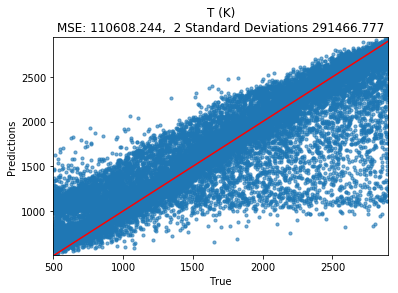

R2:  0.625783908638063


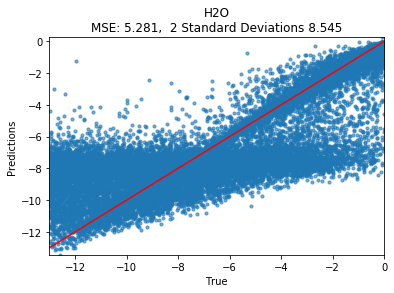

R2:  0.48733995711922606


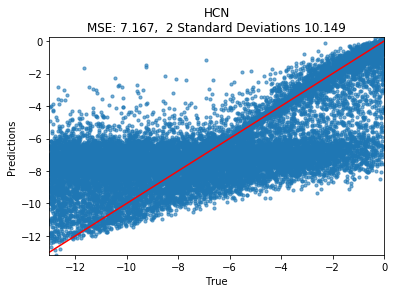

R2:  0.7210654282256135


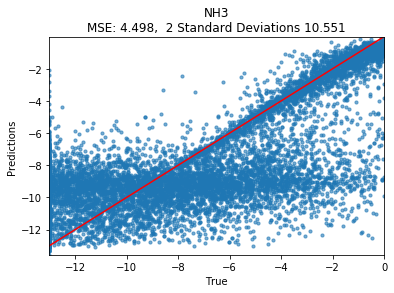

R2:  0.7504694411467636


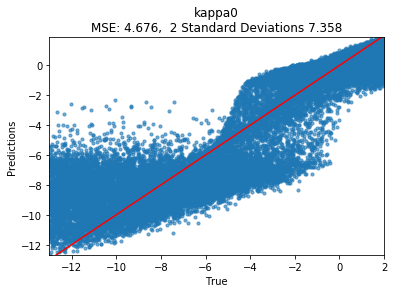

In [39]:
yyy = [-20,20] # This is just defining y = x
minx = np.min(y_data_test[:No_pred,:])
maxx = np.max(y_data_test[:No_pred,:])
miny = np.min(PRED.mean(1)[:,:])
maxy = np.max(PRED.mean(1)[:,:])
R2 =[]
for mol in range(y_data_tr.shape[-1]):
    plt.title(names[mol])
    plt.ylabel('Predictions')
    plt.xlabel('True')
    minx = np.min(y_data_test_un[:No_pred,mol])
    maxx = np.max(y_data_test_un[:No_pred,mol])
    miny = np.min(PRED_un.mean(1)[:,mol])
    maxy = np.max(PRED_un.mean(1)[:,mol])
    plt.xlim([minx,maxx])
    plt.ylim([miny,maxy])
    plt.scatter(y_data_test_un[:No_pred,mol],PRED_un.mean(1)[:,mol],s=10,alpha=0.6)
    yyy = [min(miny,minx),max(maxx,maxy)]
    plt.plot(yyy,yyy,'r')
    
#     print('For ',No_pred,' test planets:\n')
    # MSE: 
    MSE = np.mean((y_data_test_un[:No_pred,mol]  - PRED_un.mean(1)[:,mol])**2)
    sig = np.std((y_data_test_un[:No_pred,mol]  - PRED_un.mean(1)[:,mol])**2)
#     print(names[mol] + ' MSE: ',MSE, ' 2 Standard Deviations on MSE: ',2*sig)
    plt.title(names[mol] + '\nMSE: %.3f,  2 Standard Deviations %.3f' % (MSE,sig))
    R2.append(metrics.r2_score(y_data_test_un[:No_pred,mol], PRED_un.mean(1)[:,mol]))
    print('R2: ',metrics.r2_score(y_data_test_un[:No_pred,mol], PRED_un.mean(1)[:,mol]))
#     plt.savefig('./figures/test/chol_loss_NN_validation'+names[mol]+'pred_vs_true.pdf')
    plt.show()

In [40]:
print(R2)

[0.7704730381816205, 0.625783908638063, 0.48733995711922606, 0.7210654282256135, 0.7504694411467636]


In [41]:
np.mean(R2)

0.6710263546622572

## HELA PLOTTING FUNCTION

In [42]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn import metrics, neighbors
from sklearn.preprocessing import MinMaxScaler


def predicted_vs_real(y_real, y_pred, names, ranges):
    
    num_plots = y_pred.shape[1]
    num_plot_rows = int(np.sqrt(num_plots))
    num_plot_cols = (num_plots - 1) // num_plot_rows + 1
    
    fig, axes = plt.subplots(num_plot_rows, num_plot_cols,
                             figsize=(5*num_plot_cols, 5*num_plot_rows))
    
    for dim, (ax, name_i, range_i) in enumerate(zip(axes.ravel(), names, ranges)):
        
        current_real = y_real[:, dim]
        current_pred = y_pred[:, dim]
        
        r2 = metrics.r2_score(current_real, current_pred)
        label = "$R^2 = {:.3f}$".format(r2)
        ax.plot(current_real, current_pred, '.', label=label)
        
        ax.plot(range_i, range_i, '--', linewidth=3, color="C3")
        
        ax.axis("equal")
        ax.grid()
        ax.set_xlim(range_i)
        ax.set_ylim(range_i)
        ax.set_xlabel("Real {}".format(name_i), fontsize=18)
        ax.set_ylabel("Predicted {}".format(name_i), fontsize=18)
        ax.legend(loc="upper left", fontsize=14)
    
    fig.tight_layout()
    return fig


def feature_importances(forests, names, colors):
    
    num_plots = len(forests)
    num_plot_rows = (num_plots - 1) // 2 + 1
    num_plot_cols = 2
    
    fig, axes = plt.subplots(num_plot_rows, num_plot_cols,
                             figsize=(15, 3.5*num_plot_rows))
    
    for ax, forest_i, name_i, color_i in zip(axes.ravel(), forests, names, colors):
        ax.bar(np.arange(len(forest_i.feature_importances_)), forest_i.feature_importances_,
               label="Importance for {}".format(name_i),
               width=0.4, color=color_i)
        ax.set_xlabel("Feature index", fontsize=18)
        ax.legend(fontsize=16)
        ax.grid()
    
    fig.tight_layout()
    return fig


def posterior_matrix(estimations, y, names, ranges, colors, soft_colors=None):
    
    cmaps = [LinearSegmentedColormap.from_list("MyReds", [(1, 1, 1), c], N=256)
             for c in colors]
    
    ranges = np.array(ranges)
    
    if soft_colors is None:
        soft_colors = colors
    
    num_dims = estimations.shape[1]
    
    fig, axes = plt.subplots(nrows=num_dims, ncols=num_dims,
                             figsize=(2 * num_dims, 2 * num_dims))
    fig.subplots_adjust(left=0.07, right=1-0.05,
                        bottom=0.07, top=1-0.05,
                        hspace=0.05, wspace=0.05)
    
    for ax, dims in zip(axes.flat, product(range(num_dims), range(num_dims))):
        dims = list(dims[::-1])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.title.set_visible(False)
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
            ax.yaxis.set_visible(True)
            if names is not None:
                ax.set_ylabel(names[dims[1]], fontsize=18)
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
            ax.yaxis.set_visible(True)
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_visible(True)
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')
            ax.xaxis.set_visible(True)
            if names is not None:
                ax.set_xlabel(names[dims[0]], fontsize=18)
        if ax.is_first_col() and ax.is_first_row():
            ax.yaxis.set_visible(False)
            ax.set_ylabel("")
        if ax.is_last_col() and ax.is_last_row():
            ax.yaxis.set_visible(False)
        
        if dims[0] < dims[1]:
            locations, kd_probs, *_ = _kernel_density_joint(estimations[:, dims], ranges[dims])
            ax.contour(locations[0], locations[1],
                       kd_probs,
                       colors=colors[dims[0]],
                       linewidths=0.5
                       # 'copper', # 'hot', 'magma' ('copper' with white background)
                      )
            histogram, grid_x, grid_y = _histogram(estimations[:, dims], ranges[dims])
            ax.pcolormesh(grid_x, grid_y, histogram, cmap=cmaps[dims[0]])
            
            expected = np.median(estimations[:, dims], axis=0)
            ax.plot([expected[0], expected[0]], [ranges[dims[1]][0], ranges[dims[1]][1]], '-', linewidth=1, color='#222222')
            ax.plot([ranges[dims[0]][0], ranges[dims[0]][1]], [expected[1], expected[1]], '-', linewidth=1, color='#222222')
            ax.plot(expected[0], expected[1], '.', color='#222222')
            ax.axis('normal')
            if y is not None:
                real = y[dims]
                ax.plot(real[0], real[1], '*', markersize=10, color='#FF0000')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        elif dims[0] > dims[1]:
            ax.plot(estimations[:, dims[0]], estimations[:, dims[1]], '.', color=soft_colors[dims[1]])
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     ranges[dims[1]][0], ranges[dims[1]][1]])
        else:
            histogram, bins = _histogram(estimations[:, dims[:1]], ranges=ranges[dims[:1]])
            ax.bar(bins[:-1], histogram, color=soft_colors[dims[0]], width=bins[1]-bins[0])
            
            kd_probs = histogram
            expected = np.median(estimations[:, dims[0]])
            ax.plot([expected, expected], [0, 1.1 * kd_probs.max()], '-', linewidth=1, color='#222222')
            
            if y is not None:
                real = y[dims[0]]
                ax.plot([real, real], [0, kd_probs.max()], 'r-')
            ax.axis([ranges[dims[0]][0], ranges[dims[0]][1],
                     0, 1.1 * kd_probs.max()])
    
    # fig.tight_layout(pad=0)
    return fig


def _min_max_scaler(ranges, feature_range=(0, 100)):
    res = MinMaxScaler()
    res.data_max_ = ranges[:, 1]
    res.data_min_ = ranges[:, 0]
    res.data_range_ = res.data_max_ - res.data_min_
    res.scale_ = (feature_range[1] - feature_range[0]) / (ranges[:, 1] - ranges[:, 0])
    res.min_ = -res.scale_ * res.data_min_
    res.n_samples_seen_ = 1
    res.feature_range = feature_range
    return res


def _kernel_density_joint(estimations, ranges, bandwidth=1/25):
    
    ndims = len(ranges)
    
    scaler = _min_max_scaler(ranges, feature_range=(0, 100))
    
    bandwidth = bandwidth * 100
    # step = 1.0
    
    kd = neighbors.KernelDensity(bandwidth=bandwidth).fit(scaler.transform(estimations))
    locations1d = np.arange(0, 100, 1)
    locations = np.reshape(np.meshgrid(*[locations1d] * ndims), (ndims, -1)).T
    kd_probs = np.exp(kd.score_samples(locations))
    
    shape = (ndims,) + (len(locations1d),) * ndims
    locations = scaler.inverse_transform(locations)
    locations = np.reshape(locations.T, shape)
    kd_probs = np.reshape(kd_probs, shape[1:])
    return locations, kd_probs, kd


def _histogram(estimations, ranges, bins=20):
    
    if len(ranges) == 1:
        histogram, edges = np.histogram(estimations[:, 0], bins=bins, range=ranges[0])
        return histogram, edges
    
    if len(ranges) == 2:
        histogram, xedges, yedges = np.histogram2d(estimations[:, 0], estimations[:, 1], bins=bins, range=ranges)
        grid_x, grid_y = np.meshgrid(xedges, yedges)
        return histogram.T, grid_x, grid_y, 

## Go back to original scale: (Un-normalise)

In [43]:

def sample_mult(means,prec,n_samples):
    '''
    means: NxD
    sigmas: NxDxD
    '''
    N,D = means.shape
    S = np.zeros((n_samples, D))
    
    m = np.mean(means,0)
    prec = np.mean(prec,0)
    sig = np.linalg.inv(prec)
    
    for s in range(n_samples):
        S[s,:] = np.random.multivariate_normal(m,sig)
    return S

In [44]:
S = sample_mult(PRED_un[0,:,:num_features],PREC_un[0,:,:num_features],n_samples=100)

In [45]:
S.shape

(100, 5)

In [46]:
S_re = S.reshape((-1,5))

A planet sample $p_s$ is drawn from a multivariate normal, where the parameters of the normal are the expected values from the output of a BNN. (Expectation over the posterior over the weights).

$$ p_s \sim \mathcal{N}(\mathrm{E}\left[\mu\right], \mathrm{E}\left[\Sigma\right]) $$

To unormalise: we must do $(\mu + m_{\mathrm{train}})/\sigma$ and $\mathrm{diag}(\sigma_{\mathrm{train}})\mathrm{E}\left[\Sigma\right]\mathrm{diag}(\sigma_{\mathrm{train}})$

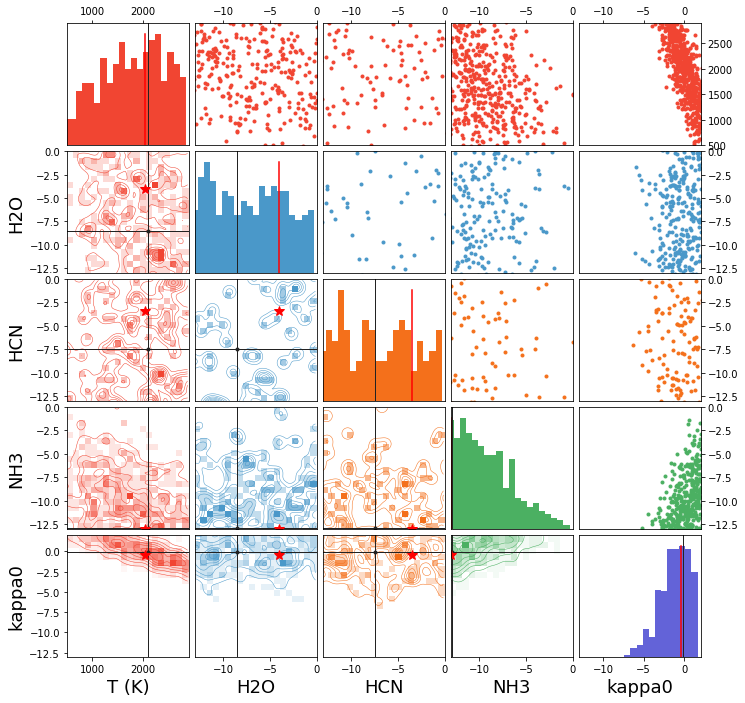

In [50]:
planet_id = 2; #101#50, 71, 11, 101, 50 51! 889! 0 is earth if in other cell -1 is selected
num_features = 12
#delta = 0.05
ranges=[[x, y] for x, y in zip(y_data_val_un.min(0), y_data_val_un.max(0))]
# FOR ZOOMED IN UNCOMMENT LINE BELOW
#ranges=[[x, y] for x, y in zip(PRED_un[planet_id,:,:num_features].min(0), PRED_un[planet_id,:,:num_features].max(0))]
# [[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, 1],[0, 1]]
# names =  ["H20", "CO2", "O2", "N2", "CH4", "C2H6", "O3", "N2O", "NH3", "SO2", "C25H28N6O7", "?"]
#names =  ["H20", "CO2", "O2", "N2", "CH4"]
#colors = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"]#, "#F14532", "#4a98c9", "#f4701b", 
#           "#4bb062", "#6363d8","#4bb062", "#6363d8","#4a98c9", "#f4701b"]
# colors = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8", "#F14532", "#4a98c9", "#f4701b", 
#            "#4bb062", "#6363d8","#4bb062", "#6363d8","#4a98c9", "#f4701b"]
###
#  ADD NOISE TERM (gaussian likelihood)
###
# v_noise = bnn.tau **(-1) * y_data.var(0)[:num_features]
# noise = np.random.multivariate_normal(mean = np.zeros((5)),cov = np.diag(v_noise),size = (bnn.T,))
# posterior_matrix(PRED_un[planet_id,:,:num_features] + noise, y_data_val_un[planet_id,:num_features], names, ranges, colors, soft_colors=None)

# S = sample(PRED_un[planet_id,:,:num_features],SIG_un[planet_id,:,:num_features],n_samples_per_output=100)
# S_re = S.reshape((-1,5))

S = sample_mult(PRED_un[planet_id,:,:num_features],PREC_un[planet_id,:,:num_features],n_samples=1000)
S_re = S.reshape((-1,5))


posterior_matrix(S_re, y_data_val_un[planet_id,:num_features], names, ranges, colors, soft_colors=None)


# plt.savefig('./figures/valid/BNN_het_chol_loss_'+str(planet_id)+'.pdf')
plt.show()

## WASP:

In [62]:
x_data_wasp = np.load('../../train/WASP12b_hela.npy')
x_data_wasp = (x_data_wasp - x_data.mean(0))/x_data.std(0)

In [64]:
y_wasp_pred = np.array([std_model.predict(x_data_wasp.reshape((1,-1))) for _ in range(T)]).squeeze()

In [66]:
PRED_un_wasp = y_wasp_pred[:,:D] * y_data.std(0)[:num_features] + y_data.mean(0)[:num_features]

In [71]:
S_inv, chols = chol(y_wasp_pred[None,:,D:],D)

In [72]:
PREC_un_wasp = np.matmul(np.diag(y_data.std(0)[:num_features]**-1),np.matmul(S_inv ,np.diag(y_data.std(0)[:num_features]**-1)))

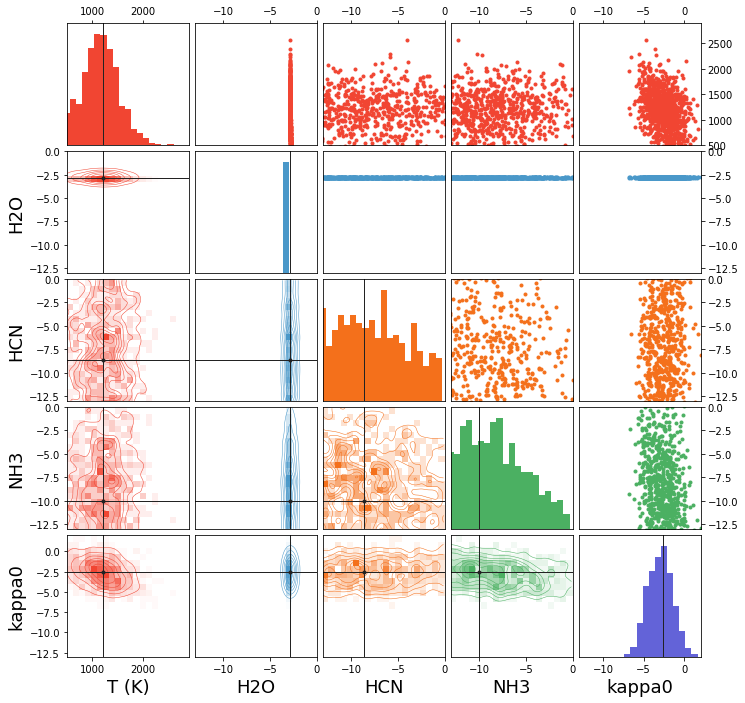

In [81]:
planet_id = 2; #101#50, 71, 11, 101, 50 51! 889! 0 is earth if in other cell -1 is selected
num_features = 12
#delta = 0.05
ranges=[[x, y] for x, y in zip(y_data_val_un.min(0), y_data_val_un.max(0))]
# FOR ZOOMED IN UNCOMMENT LINE BELOW
#ranges=[[x, y] for x, y in zip(PRED_un[planet_id,:,:num_features].min(0), PRED_un[planet_id,:,:num_features].max(0))]
# [[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, .1],[0, 1],[0, 1]]
# names =  ["H20", "CO2", "O2", "N2", "CH4", "C2H6", "O3", "N2O", "NH3", "SO2", "C25H28N6O7", "?"]
#names =  ["H20", "CO2", "O2", "N2", "CH4"]
#colors = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8"]#, "#F14532", "#4a98c9", "#f4701b", 
#           "#4bb062", "#6363d8","#4bb062", "#6363d8","#4a98c9", "#f4701b"]
# colors = ["#F14532", "#4a98c9", "#f4701b", "#4bb062", "#6363d8", "#F14532", "#4a98c9", "#f4701b", 
#            "#4bb062", "#6363d8","#4bb062", "#6363d8","#4a98c9", "#f4701b"]
###
#  ADD NOISE TERM (gaussian likelihood)
###
# v_noise = bnn.tau **(-1) * y_data.var(0)[:num_features]
# noise = np.random.multivariate_normal(mean = np.zeros((5)),cov = np.diag(v_noise),size = (bnn.T,))
# posterior_matrix(PRED_un[planet_id,:,:num_features] + noise, y_data_val_un[planet_id,:num_features], names, ranges, colors, soft_colors=None)

# S = sample(PRED_un[planet_id,:,:num_features],SIG_un[planet_id,:,:num_features],n_samples_per_output=100)
# S_re = S.reshape((-1,5))

S = sample_mult(PRED_un_wasp,PREC_un_wasp[0],n_samples=1000)
S_re = S.reshape((-1,5))


posterior_matrix(S_re, None, names, ranges, colors, soft_colors=None)


# plt.savefig('./figures/valid/BNN_het_chol_loss_WASP.pdf')
plt.show()